# Equações do Sistema

$G(s) = \dfrac{1}{\tau \cdot C_2R_1} \cdot \dfrac{1}{s^2+\dfrac{\tau + C_1R_1}{\tau\cdot C_2R_1}+\dfrac{1}{\tau \cdot C_2R_1}}$, $\tau = C_1\cdot R_2$

$ω = \sqrt{\dfrac{1}{\tau \cdot C_2R_1}}$

$ζ = \dfrac{\tau+C_1R_1}{2\tau \cdot C_2\cdot R_1 \cdot \sqrt{\dfrac{1}{\tau \cdot C_2R_1}}} \ 
   = \dfrac{\tau+C_1R_1}{2\tau \cdot C_2\cdot R_1 \cdot ω}$

In [1]:
# Módulos
import numpy as np
# Cálculo de Parâmetros
NT = 18             # Emanuel(7) + Staub(5) + Araldi(6)
R1 = NT*2e3         # Resistência de Entrada
R2 = 18e3           # Resistência do Circuito RC
C1 = 100e-9         # Capacitância do Circuito RC
C2 = 680e-9         # Capacitância do Ampop
####
z  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
w2 = 1/(C1*C2*R1*R2)
w  = np.sqrt(w2)
####
print("ζ: ", round(z, 3))
print("ω: ", round(w, 3))

ζ:  0.407
ω:  150.646


In [11]:
# Cálculo de Valores Importantes do Circuito
Mp = np.exp(-np.pi*z/np.sqrt(1-z**2))
tp = np.pi/(w*np.sqrt(1-z**2))
τ  = 1/(z*w)
Ts = 4*τ
####
print("Mp: ", round(Mp*100, 3), "%")    # Simulado: 24.698%
print("tp: ", round(tp*1e3, 3), "ms")   # Simulado: 22.80 ms
print("τ : ", round(τ*1e3 , 3), "ms")   # Simulado: NA
print("Ts: ", round(Ts*1e3, 3), "ms")   # Simulado: 55.82 ms (difícil determinar, mas entre ~56 e ~69)

Mp:  24.69 %
tp:  22.828 ms
τ :  16.32 ms
Ts:  65.28 ms


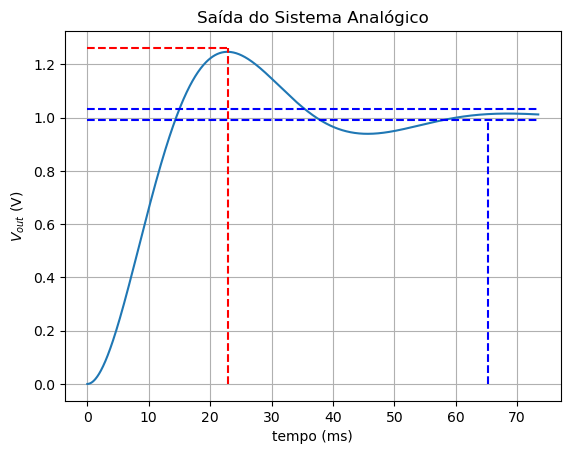

In [66]:
import matplotlib.pyplot as plt
import scipy.signal as sp

t = np.linspace(0, (Ts+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = sp.lti([w2], [1, 2*z*w, w2])
t, y = sp.step(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Analógico")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=tp])), 'r--')
plt.plot([tp*1e3, tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ys  = y[np.abs(y - y[-1]*(1-2e-2)) <= 1e-5]
plt.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')
plt.savefig("Analogico.svg", format="svg")

In [74]:
# Comparando valores do gráfico com os calculados
Tp_ms = tms[y == np.max(y)]
Mp_es = 100*(np.max(y) - 1)

print("Tp_ms: ", round(Tp_ms[0], 3), "ms")
print("Mp_es: ", round(Mp_es, 3), "%")

Tp_ms:  22.863 ms
Mp_es:  24.69 %


Podemos ver que os valores calculados, estimados e simulados concordam um com o outro, faltando apenas a comparação em bancada para determinar a validade dos cálculos

In [77]:
from PyLTSpice import RawRead

LTR = RawRead("Analogico.raw")

print(LTR.get_trace_names())
print(LTR.get_raw_property())

['time', 'V(vin)', 'V(n001)', 'V(n002)', 'V(vout)', 'I(C2)', 'I(C1)', 'I(R2)', 'I(R1)', 'I(V1)', 'Ix(u1:3)']
OrderedDict([('Filename', WindowsPath('Analogico.raw')), ('Title', '* C:\\Users\\emanuel\\Documents\\Uni\\Controle_2\\Analogico\\Analogico.asc'), ('Date', 'Sun Oct 13 15:46:11 2024'), ('Plotname', 'Transient Analysis'), ('Flags', 'real forward'), ('No. Variables', 11), ('No. Points', 59), ('Offset', '0.0000000000000000e+000'), ('Command', 'Linear Technology Corporation LTspice XVII -- Alternate Solver'), ('Backannotation', 'u1 1 2 3'), ('Variables', ['time', 'V(vin)', 'V(n001)', 'V(n002)', 'V(vout)', 'I(C2)', 'I(C1)', 'I(R2)', 'I(R1)', 'I(V1)', 'Ix(u1:3)'])])


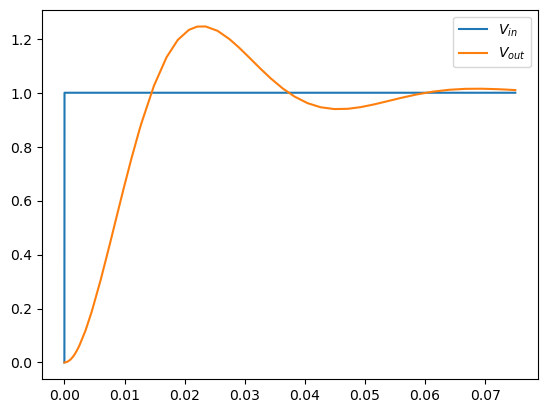

In [79]:
Vout  = LTR.get_trace("V(vout)")
Vin   = LTR.get_trace("V(vin)")
####
time  = LTR.get_trace("time")
steps = LTR.get_steps()
for step in range(len(steps)):
    # print(steps[step])
    plt.plot(time.get_wave(step), Vin.get_wave(step), label=steps[step])
    plt.plot(time.get_wave(step), Vout.get_wave(step), label=steps[step])

plt.legend(["$V_{in}$", "$V_{out}$"])
plt.show()

In [88]:
Mp_sim = (np.max(Vout)-1)
Tp_sim = time[Vout == np.max(Vout)][0]

print("Mp simulado: ", round(100*Mp_sim, 3), "%")
print("Tp simulado: ", round(1e3*Tp_sim, 3), "s")

Mp simulado:  24.568 %
Tp simulado:  23.501 s


In [95]:
diff_Mp = 100*(Mp-Mp_sim)/Mp
diff_Tp = 100*(tp-Tp_sim)/tp

print("diferença entre Mp calculado e simulado: ", round(diff_Mp, 3), "%")
print("diferença entre Tp calculado e simulado: ", round(diff_Tp, 3), "%")

diff_Tp2 = 100*(Tp_ms[0]-1e3*Tp_sim)/Tp_ms[0] # Tempo de pico simulado por G(s)
print("diferença entre Tp simulado por G(s) e pelo LTSpice: ", round(diff_Tp2, 3), "%")

diferença entre Mp calculado e simulado:  0.497 %
diferença entre Tp calculado e simulado:  -2.949 %
diferença entre Tp simulado por G(s) e pelo LTSpice:  -2.791 %


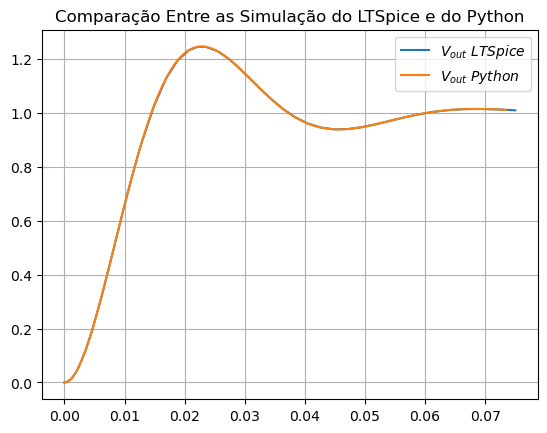

In [106]:
for step in range(len(steps)):
    # print(steps[step])
    plt.plot(time.get_wave(step), Vout.get_wave(step), label=steps[step])

plt.plot(t, y)
plt.legend(["$V_{out} \ LTSpice$", "$V_{out} \ Python$"])
plt.title("Comparação Entre as Simulação do LTSpice e do Python")
plt.grid(True, 'both')

plt.savefig("Comparacao_LT_Gs.svg", format="svg")

Podemos ver que o resultado calculado a partir de G(s) e o valor simulado pelo LTSpice são quase idênticos